In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

warnings.filterwarnings('ignore')#to filter all the warnings
pd.set_option('float_format', '{:.4f}'.format)# to keep the float values short

In [2]:
df = pd.read_csv('../data/model_data/youtube_num.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category_id          40949 non-null  int64 
 1   views                40949 non-null  int64 
 2   likes                40949 non-null  int64 
 3   dislikes             40949 non-null  int64 
 4   comment_count        40949 non-null  int64 
 5   category_name        40949 non-null  object
 6   total_trending_days  40949 non-null  int64 
 7   published_year       40949 non-null  int64 
 8   published_month      40949 non-null  int64 
 9   published_week       40949 non-null  int64 
 10  published_day        40949 non-null  int64 
 11  published_hour       40949 non-null  int64 
 12  published_minute     40949 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 4.1+ MB


In [3]:
dummies_category = pd.get_dummies(df['category_name'])

In [4]:
df = pd.concat([df, dummies_category], axis=1)
df.drop(['category_id', 'category_name'], axis=1, inplace=True)

## Preparacion de los datos

In [5]:
X = df.copy()
y = X.pop('likes')

In [6]:
X.head(1)

,views,dislikes,comment_count,total_trending_days,published_year,published_month,published_week,published_day,published_hour,published_minute,...,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events
0,81377,25,177,1,2017,11,46,13,2,5,...,0,0,0,0,0,0,0,0,1,0


In [7]:
ct = make_column_transformer(
    (StandardScaler(),
    make_column_selector(dtype_include=np.number))
)

In [8]:
X = ct.fit_transform(X)

## Construccion del modelo

In [9]:
model_base = models.Sequential()

model_base.add(layers.Flatten(input_shape=[X.shape[1]]))
model_base.add(layers.Dense(128, activation='relu'))
model_base.add(layers.BatchNormalization())
model_base.add(layers.Dropout(0.2))

model_base.add(layers.Dense(64, activation='relu'))
model_base.add(layers.BatchNormalization())
model_base.add(layers.Dropout(0.2))

model_base.add(layers.Dense(1))

2022-02-07 19:59:59.474633: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-07 19:59:59.476441: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-07 19:59:59.480046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
model_base.compile(optimizer='adam',
                    loss='mse',
                    metrics=['mae'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [12]:
history = model_base.fit(X_train, y_train,
                        batch_size=256,
                        epochs=50,
                        verbose=0,
                        validation_split=0.2)

2022-02-07 19:59:59.977916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-07 19:59:59.986278: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400005000 Hz


In [13]:
model_base.evaluate(X_test, y_test)

384/384 [==============================] - 4s 12ms/step - loss: 65466720256.0000 - mae: 75910.5703


[65466720256.0, 75910.5703125]

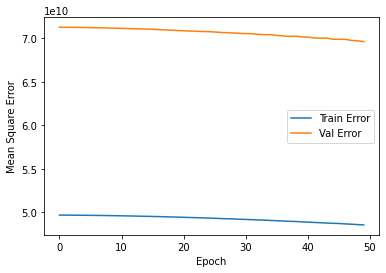

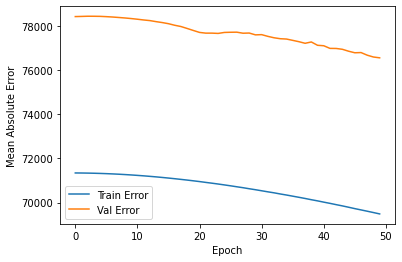

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

## KerasTuner

In [15]:
import keras_tuner as kt

In [16]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=[X.shape[1]]))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=256, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model_base.add(layers.Dropout(0.2))

  hp_units2 = hp.Int('units2', min_value=64, max_value=256, step=32)
  model_base.add(layers.Dense(units=hp_units2, activation='relu'))
  model_base.add(layers.BatchNormalization())

  model.add(keras.layers.Dense(1))
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.mse,
                metrics=['mae'])

  return model

In [17]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=10,
                     factor=3,
                     directory='../test/my_test_2',
                     project_name='intro_to_kt1')

In [18]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

In [19]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')},The optimal number of units in the second densely-connected
layer is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |320               |?                 
units2            |96                |?                 
learning_rate     |0.0001            |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Invalid model 0/5


Traceback (most recent call last):
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_2741/3461887582.py", line 9, in model_builder
    model_base.add(layers.Dropout(0.2))
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py", line 517, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py", line 188, in add
    raise ValueError('All layers added to a Sequential model '
ValueError: All layers added to a Sequential model should have unique n

Invalid model 1/5
Invalid model 2/5


Traceback (most recent call last):
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_2741/3461887582.py", line 9, in model_builder
    model_base.add(layers.Dropout(0.2))
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py", line 517, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py", line 188, in add
    raise ValueError('All layers added to a Sequential model '
ValueError: All layers added to a Sequential model should have unique n

Invalid model 3/5


Traceback (most recent call last):
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_2741/3461887582.py", line 9, in model_builder
    model_base.add(layers.Dropout(0.2))
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py", line 517, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py", line 188, in add
    raise ValueError('All layers added to a Sequential model '
ValueError: All layers added to a Sequential model should have unique n

Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_2741/3461887582.py", line 9, in model_builder
    model_base.add(layers.Dropout(0.2))
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py", line 517, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/kennydev/anaconda3/envs/cookiecutter-project/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py", line 188, in add
    raise ValueError('All layers added to a Sequential model '
ValueError: All layers added to a Sequential model should have unique n

RuntimeError: Too many failed attempts to build model.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history_tuner = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history_tuner.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

## Conclusiones
* En los primeros modelos se usaron 11 features, correspondientes a las columnas seleccionadas en la etapa de EDA, pero este arrojaba un MAE superior a 120.000
* Se uso la función `get_dummies` de pandas para realizar un one-hot encoding sobre la columna `category_name` y de esta manera obtener mejores resultados: el MAE descendió a 60.000 (30.000 en el mejor de los casos)
* Se podría seguir usando mas features por ejemplo: modulo `Polynomical` de sklearn, pero caeriamos en el abismo de la maldicion de la dimensionalidad
* Sería relevante usar otro método de analisis como el de `mutual_information` para reconocer que features son mas utiles para el desarrollo de nuestro modelo
* Se deseaba usar la libreria de `kerastuner` para mejorar los hiperparametros de la red neuronal base creada, pero mi maquina de pruebas no soporto la cantidad de procesos, usar GPU's como las gratuitas de Google Colab, puede ser una mejora sustancial
* En general los features existentes en el dataset y sus registros, no son informacion suficiente para predecir con bajo indice de error la cantidad de likes que puede recibir un video